In [78]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


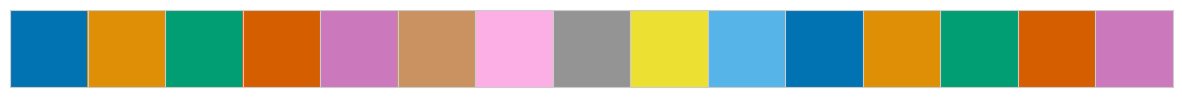

In [79]:
import sys
sys.path.insert(0, '..//src/')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import main
from common import enums, functions, schema
from pathlib import Path


sns.set_palette(sns.color_palette("colorblind", 15))
plt.rcParams['font.family'] = 'Times New Roman'
font_size = 12
params = {'axes.labelsize': font_size+2,
          'axes.titlesize':font_size+4,
          'legend.fontsize': font_size,
          'xtick.labelsize': font_size,
          'ytick.labelsize': font_size,
          'font.size': font_size}
plt.rcParams.update(params)
sns.set_style("whitegrid")
fig_format = "pdf"
dpi = 300
figsize = (12, 3.5)
figsize_map = (16, 8)
sns.palplot(sns.color_palette())

## National Grid distribution South Wales

In [80]:
south_wales_data_path = Path(
    r'C:\Users\sceac10\OneDrive - Cardiff University\General\data\Electricity substation data\national grid'
)
fn = 'lsoa_to_substations_south_wales.csv'

dataf = pd.read_csv(south_wales_data_path/fn, low_memory=False)
dataf.head()
cols_to_keep = [
    'GeographyCode', 'PRIM_NRID_NAME', 'PRIM_NRID', 'BSP_NRID_NAME',
    'BSP_NRID', 'GSP_NRID_NAME', 'GSP_NRID'
]
dataf = dataf[cols_to_keep]
dataf.head()
# dataf.to_csv(south_wales_data_path/fn)

,GeographyCode,PRIM_NRID_NAME,PRIM_NRID,BSP_NRID_NAME,BSP_NRID,GSP_NRID_NAME,GSP_NRID
0,W01000585,Penblewin,245315,Haverfordwest Grid,245312,Pembroke Power Station,245306
1,W01000585,Neyland,245309,Golden Hill Grid,245313,Pembroke Power Station,245306
2,W01000585,St Florence,245314,Golden Hill Grid,245313,Pembroke Power Station,245306
3,W01000585,Merlins Bridge,245508,Haverfordwest Grid,245312,Pembroke Power Station,245306
4,W01000585,Golden Hill Primary,253012,Golden Hill Grid,245313,Pembroke Power Station,245306


In [81]:
#include number of lsoa supplied by each substation to the table
nb_lsoa_supplied_by_substation = dataf.groupby('PRIM_NRID_NAME').agg({'GeographyCode': 'count'})
nb_lsoa_supplied_by_substation.columns = ['Number_lsoas_supplied']
nb_lsoa_supplied_by_substation.head()

,Number_lsoas_supplied
PRIM_NRID_NAME,
Aberaeron,7
Abercrave,7
Aberdare,26
Abergavenny Primary,25
Aberpergwm,12


In [82]:
dataf = pd.merge(dataf,
                 nb_lsoa_supplied_by_substation,
                 left_on='PRIM_NRID_NAME',
                 right_index=True)
dataf = dataf.sort_index()

In [83]:
fn = r'Network Headroom Report\South Wales Network Headroom Report.xlsx'
sheet_name = 'Demand headroom'
demand_headroom = pd.read_excel(south_wales_data_path / fn,
                                sheet_name=sheet_name,
                                header=0)
scenario ='Leading the Way'  #'Consumer Transformation', 'Leading the Way', 'Steady Progression', 'System Transformation', 'WPD Best View'
filt = (demand_headroom['Scenario'] == scenario)
cols_to_keep = ['Substation', '2050']
demand_headroom = demand_headroom.loc[filt, cols_to_keep]
demand_headroom.head()

,Substation,2050
1,Barry Grid Primary,-33.08
6,Broad St.Barry,4.88
11,Court Road Barry,9.85
16,Cowbridge,-7.00
21,Ship Hill Barry,11.26


In [84]:
## Merged dataset including thermal headroom

In [85]:
dataf = pd.merge(dataf,
                 demand_headroom,
                 left_on='PRIM_NRID_NAME',
                 right_on='Substation')
dataf['Thermal_demand_headroom_available_for_lsoa'] = dataf['2050'] / dataf[
    'Number_lsoas_supplied']
dataf.head()

,GeographyCode,PRIM_NRID_NAME,PRIM_NRID,BSP_NRID_NAME,BSP_NRID,GSP_NRID_NAME,GSP_NRID,Number_lsoas_supplied,Substation,2050,Thermal_demand_headroom_available_for_lsoa
0,W01000585,Penblewin,245315,Haverfordwest Grid,245312,Pembroke Power Station,245306,12,Penblewin,-64.18,-5.348333
1,W01000596,Penblewin,245315,Haverfordwest Grid,245312,Pembroke Power Station,245306,12,Penblewin,-64.18,-5.348333
2,W01000583,Penblewin,245315,Haverfordwest Grid,245312,Pembroke Power Station,245306,12,Penblewin,-64.18,-5.348333
3,W01000582,Penblewin,245315,Haverfordwest Grid,245312,Pembroke Power Station,245306,12,Penblewin,-64.18,-5.348333
4,W01000735,Penblewin,245315,Haverfordwest Grid,245312,Pembroke Power Station,245306,12,Penblewin,-64.18,-5.348333


In [ ]:
## Extract cooling demand of LSOAs in national grid south wales network

In [92]:
PATH_RESULTS = Path(
    r'C:\Users\sceac10\OneDrive - Cardiff University\General\04 - Analysis\2050 high emission')

lsoa_peak = pd.read_csv(PATH_RESULTS / 'cooling_peak_results_lsoa.csv',
                        index_col=0)
lsoa_peak.head()

,LSOA_code,Peak cooling demand (kW)
S12000033,S01006506,4583.843793
S12000033,S01006507,3443.728159
S12000033,S01006508,2542.345065
S12000033,S01006509,2118.631596
S12000033,S01006510,2817.641884


In [93]:
count_lsoas = dataf.groupby('GeographyCode').agg({'GeographyCode': 'count'})
lsoa_peak = pd.merge(lsoa_peak,
                     count_lsoas,
                     left_on='LSOA_code',
                     right_index=True)
lsoa_peak = lsoa_peak.reset_index()
lsoa_peak['Specific peak cooling demand [kW/area]'] = lsoa_peak[
    schema.VisualisationSchema.PEAK_COOLING] / lsoa_peak['GeographyCode']
lsoa_peak.head()

,index,LSOA_code,Peak cooling demand (kW),GeographyCode,Specific peak cooling demand [kW/area]
0,W06000019,W01001435,6358.303606,2,3179.151803
1,W06000019,W01001436,5659.549778,1,5659.549778
2,W06000019,W01001437,6283.774695,2,3141.887347
3,W06000019,W01001438,6101.304290,2,3050.652145
4,W06000019,W01001439,7347.919831,3,2449.306610


In [97]:
dataf = pd.merge(
    dataf,
    lsoa_peak[['LSOA_code', 'Specific peak cooling demand [kW/area]']],
    left_on='GeographyCode',
    right_on='LSOA_code')
dataf.head()

,GeographyCode,PRIM_NRID_NAME,PRIM_NRID,BSP_NRID_NAME,BSP_NRID,GSP_NRID_NAME,GSP_NRID,Number_lsoas_supplied,Substation,2050,Thermal_demand_headroom_available_for_lsoa,LSOA_code,Specific peak cooling demand [kW/area]
0,W01000585,Penblewin,245315,Haverfordwest Grid,245312,Pembroke Power Station,245306,12,Penblewin,-64.18,-5.348333,W01000585,991.914913
1,W01000585,Neyland,245309,Golden Hill Grid,245313,Pembroke Power Station,245306,8,Neyland,-18.77,-2.346250,W01000585,991.914913
2,W01000585,St Florence,245314,Golden Hill Grid,245313,Pembroke Power Station,245306,9,St Florence,-10.17,-1.130000,W01000585,991.914913
3,W01000585,Merlins Bridge,245508,Haverfordwest Grid,245312,Pembroke Power Station,245306,15,Merlins Bridge,-25.53,-1.702000,W01000585,991.914913
4,W01000585,Golden Hill Primary,253012,Golden Hill Grid,245313,Pembroke Power Station,245306,17,Golden Hill Primary,-90.79,-5.340588,W01000585,991.914913


In [107]:
substation_df = dataf.groupby('Substation').agg({'Thermal_demand_headroom_available_for_lsoa':'sum', 'Specific peak cooling demand [kW/area]':'sum'})

In [108]:
rename_dict = {
    'Thermal_demand_headroom_available_for_lsoa':
    schema.VisualisationSchema.DEMAND_HEADROOM,
    'Specific peak cooling demand [kW/area]':
    schema.VisualisationSchema.PEAK_COOLING
}
substation_df = substation_df.rename(columns=rename_dict)
substation_df[schema.VisualisationSchema.DEMAND_HEADROOM] = substation_df[
    schema.VisualisationSchema.DEMAND_HEADROOM] * 1000
substation_df.head()

,Thermal demand headroom (kW),Peak cooling demand (kW)
Substation,,
Aberaeron,-12770.0,16048.888805
Abercrave,200.0,15862.653188
Aberdare,-34226.0,102225.758869
Abergavenny Primary,-34180.0,112010.309102
Aberpergwm,5840.0,27246.916832


In [109]:
substation_df[
    schema.VisualisationSchema.DEMAND_HEADROOM_AFTER_COOLING] = substation_df[
        schema.VisualisationSchema.DEMAND_HEADROOM] - substation_df[
            schema.VisualisationSchema.PEAK_COOLING]
substation_df.head()

,Thermal demand headroom (kW),Peak cooling demand (kW),Thermal demand headroom after cooling demand (kW)
Substation,,,
Aberaeron,-12770.0,16048.888805,-28818.888805
Abercrave,200.0,15862.653188,-15662.653188
Aberdare,-34226.0,102225.758869,-136451.758869
Abergavenny Primary,-34180.0,112010.309102,-146190.309102
Aberpergwm,5840.0,27246.916832,-21406.916832


In [111]:
substation_df.to_csv(PATH_RESULTS / 'substation_analysis.csv')

In [ ]:
## Only keep the LSOAs

In [31]:
len([x for x in demand_headroom['Substation'].unique() if x in dataf['PRIM_NRID_NAME'].unique()])

182

In [18]:
cols_to_keep = [
    'GeographyCode', 'Group', 'Bulk Supply Point Name', 'Primary Substation', 'distance'
]
dataf = dataf[cols_to_keep]
dataf.tail()

,GeographyCode,Group,Bulk Supply Point Name,Primary Substation,distance
0,E01027993,Willington 132kV,Heanor,Westwood,0.000923
1,E01020056,Abham_Exeter _Landulph,Tiverton 33kV,CULLOMPTON 11kV,0.000727
2,E01024364,East Claydon 132kV,Bletchley,Fen Farm,1.513904
3,E01018284,Walpole 132kV,Spalding & South Holland,Whaplode Drove,0.379003
4,E01027595,Staythorpe 132kV,Checkerhouse,Misson,0.628969


In [19]:
dataf.sort_values('distance')

,GeographyCode,Group,Bulk Supply Point Name,Primary Substation,distance
30421,E01019885,Drakelow 132kV,Burton 33,Woodville,0.000000
5125,E01020242,Abham_Exeter _Landulph,Exeter City 33kV,EXMINSTER 11kV,0.000000
5129,W01001776,Cardiff East & Aberthaw 132 kV,NaN,Heath Hospital 11kV,0.000000
5130,W01001776,Cardiff East & Aberthaw 132 kV,NaN,Heath 11kV,0.000000
33479,E01026019,Walpole 132kV,Boston,Kirton,0.000000
...,...,...,...,...,...
42669,S01005515,Staythorpe 132kV,Checkerhouse,Misson,6.889002
42672,S01005518,Staythorpe 132kV,Checkerhouse,Misson,6.912038
42673,S01005519,Staythorpe 132kV,Checkerhouse,Misson,7.018910
42674,S01005520,Staythorpe 132kV,Checkerhouse,Misson,7.036048


In [34]:
demand_headroom

,Associated GSP Group,Bulk Supply Point,Substation,Supply Level,Voltage Level (kV),Latitude,Longitude,Scenario,Units,0,...,2029,2030,2031,2032,2033,2034,2035,2040,2045,2050
0,Cardiff East & Aberthaw 132 kV,Brynhill 33kV,Barry Grid Primary,Primary,11.0,-3.2787,51.4141,Consumer Transformation,Thermal headroom (MW),5.610,...,0.690,-0.270,-2.410,-4.610,-6.840,-8.860,-10.810,-23.370,-31.250,-35.620
1,Cardiff East & Aberthaw 132 kV,Brynhill 33kV,Barry Grid Primary,Primary,11.0,-3.2787,51.4141,Leading the Way,Thermal headroom (MW),5.610,...,-4.500,-6.650,-9.080,-11.650,-14.220,-16.420,-18.500,-26.700,-30.570,-33.080
2,Cardiff East & Aberthaw 132 kV,Brynhill 33kV,Barry Grid Primary,Primary,11.0,-3.2787,51.4141,Steady Progression,Thermal headroom (MW),5.610,...,3.090,2.280,1.550,0.790,-0.070,-0.810,-1.570,-6.940,-10.750,-13.260
3,Cardiff East & Aberthaw 132 kV,Brynhill 33kV,Barry Grid Primary,Primary,11.0,-3.2787,51.4141,System Transformation,Thermal headroom (MW),5.610,...,3.010,2.340,1.440,0.500,-0.440,-1.260,-2.080,-8.190,-10.670,-11.490
4,Cardiff East & Aberthaw 132 kV,Brynhill 33kV,Barry Grid Primary,Primary,11.0,-3.2787,51.4141,WPD Best View,Thermal headroom (MW),5.610,...,3.090,2.280,1.550,0.790,-0.070,-0.810,-1.570,-6.940,-10.750,-13.260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,Uskmouth 132 kV,Sudbrook 33kV,Sudbrook Primary,Primary,11.0,-2.7118,51.5863,Consumer Transformation,Thermal headroom (MW),13.676,...,13.586,13.486,13.386,13.216,12.866,12.516,12.146,10.496,9.916,9.866
976,Uskmouth 132 kV,Sudbrook 33kV,Sudbrook Primary,Primary,11.0,-2.7118,51.5863,Leading the Way,Thermal headroom (MW),13.676,...,13.246,13.036,12.746,12.396,11.996,11.646,11.326,10.396,10.306,10.696
977,Uskmouth 132 kV,Sudbrook 33kV,Sudbrook Primary,Primary,11.0,-2.7118,51.5863,Steady Progression,Thermal headroom (MW),13.676,...,14.066,14.066,14.046,14.026,14.006,13.956,13.916,13.266,12.256,12.096
978,Uskmouth 132 kV,Sudbrook 33kV,Sudbrook Primary,Primary,11.0,-2.7118,51.5863,System Transformation,Thermal headroom (MW),13.676,...,13.896,13.876,13.846,13.806,13.756,13.706,13.586,12.076,11.716,11.906


In [9]:
new_columns = ['Grid Supply Point', 'Primary Substation ', 'Scenario', 'Grid Reference', 'Single Transformer Site \n(YES/NO)', 'Upstream Constraint\n(YES / NO)']

# dataf.columns

[x for x in range(2024) ]

MultiIndex([(                'Unnamed: 0_level_0', 'Unnamed: 0_level_1'),
            (                 'Grid Supply Point', 'Unnamed: 1_level_1'),
            (               'Primary Substation ', 'Unnamed: 2_level_1'),
            (                          'Scenario', 'Unnamed: 3_level_1'),
            (                    'Grid Reference', 'Unnamed: 4_level_1'),
            ('Single Transformer Site \n(YES/NO)', 'Unnamed: 5_level_1'),
            (   'Upstream Constraint\n(YES / NO)', 'Unnamed: 6_level_1'),
            (        'Demand Headroom Winter MVA',                 2024),
            (        'Demand Headroom Winter MVA',                 2025),
            (        'Demand Headroom Winter MVA',                 2026),
            (        'Demand Headroom Winter MVA',                 2027),
            (        'Demand Headroom Winter MVA',                 2028),
            (        'Demand Headroom Winter MVA',                 2029),
            (        'Demand Headroom 

In [176]:
path_saving_results =Path(r'C:\Users\sceac10\OneDrive - Cardiff University\04 - Projects\25 - Geothermal district heating\04 - Data\viable_lsoas')
path_scotland_results = Path(r"C:\Users\sceac10\OneDrive - Cardiff University\04 - Projects\22 - Heat demand scotland\data")
# path_ukerc_england_wales_df = Path(r"C:\Users\sceac10\Cardiff University\National Grid Project - Documents\General\Paper\data for UKERC")
path_england_wales_df = Path(r"C:\Users\sceac10\OneDrive - Cardiff University\04 - Projects\03 - PhD\03 - Analysis\03 - LSOAs\00 - Data")
ukerc_save_data = Path(r'C:\Users\sceac10\OneDrive - Cardiff University\04 - Projects\20 - UKERC\03 - Code\flexibilitydwellings\data\UKERC\01 - Thermal_Characteristics')

path_scotland_la_region_lookup = Path(r"C:\Users\sceac10\OneDrive - Cardiff University\04 - Projects\00 - Final data\Geo_lookup_tables\Scotland_LAregionlookup.csv")
aaa
path_gb_data = Path(r'C:\Users\sceac10\OneDrive - Cardiff University\04 - Projects\00 - Final data\Annual_demand')

In [177]:
# thermal characteristics LSOA data
lookup_geolocation_df = pd.read_csv(ukerc_save_data/f"Thermal_characteristics_afterEE.csv", index_col=0)
lookup_geolocation_df.head()


,LSOA_code,Local Authority,Region,Dwelling forms,Heating systems,Average thermal capacity kJ/K,Average thermal losses kW/K,Number of dwellings,Average annual heat demand kWh,Average floor area m2,Thermal capacity level,Outdoor air design temperature degreeC
Index,,,,,,,,,,,,
0,E01000001,City of London,London,flat,oil boiler,7743.573923,0.190661,12.0,8115.289346,77.435739,low,-2.0
1,E01000001,City of London,London,semi-detached,gas boiler,9757.884426,0.262593,2.0,11176.994057,97.578844,low,-2.0
2,E01000001,City of London,London,terraced,gas boiler,17584.164375,0.436325,1.0,18571.754902,175.841644,low,-2.0
3,E01000001,City of London,London,terraced,resistance heating,6526.000000,0.062456,10.0,2658.375704,65.260000,low,-2.0
4,E01000001,City of London,London,flat,gas boiler,5785.363636,0.114664,95.0,4880.555556,57.853636,low,-2.0


In [178]:

lookup_lsoa_LA = dict(zip(lookup_geolocation_df['LSOA_code'].values, lookup_geolocation_df['Local Authority'].values))
lookup_lsoa_Region = dict(zip(lookup_geolocation_df['LSOA_code'].values, lookup_geolocation_df['Region'].values))


In [179]:
scenario = 'before'
england_wales_df = pd.read_csv(path_england_wales_df/f"LSOAs_in_England_Wales_{scenario}_EE_heat_demand.csv")
england_wales_df.columns = [x.lower() for x in england_wales_df.columns]
england_wales_df.head()

,lsoa11cd,n_households 2011,rurality,msoa11cd,lad11cd,local authority,detached no central heating 2011,number of detached gas boiler in 2011,number of detached resistance heating in 2011,number of detached oil boiler in 2011,...,epc efficiency d to d,epc efficiency e to d,epc efficiency f to d,epc efficiency g to d,epc efficiency e to e,epc efficiency f to e,epc efficiency g to e,epc efficiency f to f,epc efficiency g to f,epc efficiency g to g
0,E01000001,876,Rurality_Urban >10K,E02000001,E09000001,City of London,0.0,0.0,0.0,0.0,...,-0.022346,-0.020512,-0.015392,-0.012960,-0.020716,-0.016850,-0.014638,-0.021551,-0.017881,NaN
1,E01000002,830,Rurality_Urban >10K,E02000001,E09000001,City of London,0.0,0.0,0.0,0.0,...,-0.022346,-0.021067,-0.015392,-0.012960,-0.020716,-0.016850,-0.014638,-0.021551,-0.017881,NaN
2,E01000003,817,Rurality_Urban >10K,E02000001,E09000001,City of London,0.0,0.0,0.0,0.0,...,-0.020728,-0.020100,-0.015392,-0.012960,-0.020716,-0.016850,-0.014638,-0.021551,-0.017881,NaN
3,E01000005,467,Rurality_Urban >10K,E02000001,E09000001,City of London,0.0,1.0,0.0,0.0,...,-0.022384,-0.020857,-0.015392,-0.012960,-0.020716,-0.016850,-0.014638,-0.021551,-0.019133,NaN
4,E01000006,543,Rurality_Urban >10K,E02000017,E09000002,Barking and Dagenham,2.0,26.0,1.0,0.0,...,-0.024497,-0.015810,-0.014882,-0.012923,-0.015369,-0.016717,-0.014027,-0.018572,-0.015320,-0.021505


In [180]:
england_wales_df.columns = [x+" (m2)" if "average floor area" in x else x for x in england_wales_df.columns ]
for x in england_wales_df.columns:
  print(x)

lsoa11cd
n_households 2011
rurality
msoa11cd
lad11cd
local authority
detached no central heating 2011
number of detached gas boiler in 2011
number of detached resistance heating in 2011
number of detached oil boiler in 2011
number of detached biomass boiler in 2011
semi-detached no central heating 2011
number of semi-detached gas boiler in 2011
number of semi-detached resistance heating in 2011
number of semi-detached oil boiler in 2011
number of semi-detached biomass boiler in 2011
terraced no central heating 2011
number of terraced gas boiler in 2011
number of terraced resistance heating in 2011
number of terraced oil boiler in 2011
number of terraced biomass boiler in 2011
flat no central heating 2011
number of flat gas boiler in 2011
number of flat resistance heating in 2011
number of flat oil boiler in 2011
number of flat biomass boiler in 2011
area (km2)
road length (m)
total number of domestic electricity meters 2018
n_households 2018
number of detached gas boiler in 2018
number

In [181]:
scotland_df = pd.read_csv(path_scotland_results/"full_scotland_results.csv", index_col=0)
scotland_df.columns = [x.lower() for x in scotland_df.columns]
scotland_df.columns = [c.replace('resistance', 'resistance heating') for c in scotland_df.columns]
scotland_df.columns = [c.replace('solid fuel boiler', 'biomass boiler') for c in scotland_df.columns]
scotland_df.head()

,lsoa11cd,msoa11cd,ladcd,ladnm,average heat demand before energy efficiency measures for detached gas boiler (kwh),average heat demand before energy efficiency measures for detached oil boiler (kwh),average heat demand before energy efficiency measures for detached resistance heating (kwh),average heat demand before energy efficiency measures for detached biomass boiler (kwh),average heat demand before energy efficiency measures for flat gas boiler (kwh),average heat demand before energy efficiency measures for flat oil boiler (kwh),...,total heat demand before energy efficiency measures of flat resistance heating in 2018 (kwh),total heat demand after energy efficiency measures of flat resistance heating in 2018 (kwh),total heat demand before energy efficiency measures of flat gas boiler in 2018 (kwh),total heat demand after energy efficiency measures of flat gas boiler in 2018 (kwh),total heat demand before energy efficiency measures of flat biomass boiler in 2018 (kwh),total heat demand after energy efficiency measures of flat biomass boiler in 2018 (kwh),total heat demand before energy efficiency measures of flat oil boiler in 2018 (kwh),total heat demand after energy efficiency measures of flat oil boiler in 2018 (kwh),road length (m),area (km2)
3629,S01006506,S02001236,S12000033,aberdeen city,21438.468750,19968.000000,14088.5,31384.75,7846.394737,15683.666667,...,524564.090909,357768.209080,1.498661e+06,1.212025e+06,26119.0,14889.283257,0.000000,0.000000,7144.704905,4.388802
853,S01006507,S02001236,S12000033,aberdeen city,21655.277778,21845.000000,10184.0,31384.75,9522.961538,15683.666667,...,253269.000000,151087.556211,4.951940e+05,3.861348e+05,26119.0,14889.283257,0.000000,0.000000,3562.459752,0.221747
5987,S01006508,S02001236,S12000033,aberdeen city,22849.600000,27226.631579,13177.0,31384.75,7988.817391,15683.666667,...,405157.388889,271352.684156,1.318155e+06,1.118214e+06,0.0,0.000000,0.000000,0.000000,2689.130582,0.270195
839,S01006509,S02001236,S12000033,aberdeen city,20255.000000,27226.631579,12411.0,31384.75,8299.315789,15683.666667,...,241525.769231,143893.714008,4.730610e+05,3.747631e+05,0.0,0.000000,0.000000,0.000000,2029.960587,0.096254
5159,S01006510,S02001236,S12000033,aberdeen city,22805.769231,27226.631579,14088.5,31384.75,7985.275000,15683.666667,...,57800.000000,23745.007514,6.947189e+05,5.595759e+05,0.0,0.000000,15683.666667,9060.830466,2312.863906,0.180077


In [182]:
lookup_lsoa_LA_scotland = dict(scotland_df[['lsoa11cd', 'ladnm']].values)

lookup_la_region_scotland = pd.read_csv(path_scotland_la_region_lookup, index_col=0)
lookup_la_region_scotland = dict(lookup_la_region_scotland.values)

In [183]:
gb_df = pd.concat([scotland_df, england_wales_df], axis=0)#.dropna(axis=1)

In [184]:
cols_to_keep = ['lsoa11cd', 'msoa11cd', 'road length (m)', 'area (km2)']
cols_to_keep = cols_to_keep + [x for x in gb_df.columns if f"average heat demand {scenario} energy efficiency measures for" in x]
cols_to_keep = cols_to_keep + [x for x in gb_df.columns if "average floor area" in x]
cols_to_keep = cols_to_keep + [x for x in gb_df.columns if "number of" in x and 'in 2018' in x and 'total' not in x]
cols_to_keep = cols_to_keep + [x for x in gb_df.columns if "number of" in x and 'in 2011' in x and 'total' not in x]
cols_to_keep

['lsoa11cd',
 'msoa11cd',
 'road length (m)',
 'area (km2)',
 'average heat demand before energy efficiency measures for detached gas boiler (kwh)',
 'average heat demand before energy efficiency measures for detached oil boiler (kwh)',
 'average heat demand before energy efficiency measures for detached resistance heating (kwh)',
 'average heat demand before energy efficiency measures for detached biomass boiler (kwh)',
 'average heat demand before energy efficiency measures for flat gas boiler (kwh)',
 'average heat demand before energy efficiency measures for flat oil boiler (kwh)',
 'average heat demand before energy efficiency measures for flat resistance heating (kwh)',
 'average heat demand before energy efficiency measures for flat biomass boiler (kwh)',
 'average heat demand before energy efficiency measures for semi-detached gas boiler (kwh)',
 'average heat demand before energy efficiency measures for semi-detached oil boiler (kwh)',
 'average heat demand before energy effic

In [185]:
gb_df = gb_df[cols_to_keep]
gb_df['Region'] = gb_df['lsoa11cd'].map(lookup_lsoa_Region)
gb_df['Local Authority'] = gb_df['lsoa11cd'].map(lookup_lsoa_LA)
gb_df['Local Authority'] = gb_df['Local Authority'].fillna(gb_df['lsoa11cd'].map(lookup_lsoa_LA_scotland))
gb_df['Region'] = gb_df['Region'].fillna(gb_df['Local Authority'].map(lookup_la_region_scotland))
gb_df.head()

,lsoa11cd,msoa11cd,road length (m),area (km2),average heat demand before energy efficiency measures for detached gas boiler (kwh),average heat demand before energy efficiency measures for detached oil boiler (kwh),average heat demand before energy efficiency measures for detached resistance heating (kwh),average heat demand before energy efficiency measures for detached biomass boiler (kwh),average heat demand before energy efficiency measures for flat gas boiler (kwh),average heat demand before energy efficiency measures for flat oil boiler (kwh),...,number of semi-detached gas boiler in 2011,number of semi-detached oil boiler in 2011,number of semi-detached resistance heating in 2011,number of semi-detached biomass boiler in 2011,number of terraced gas boiler in 2011,number of terraced oil boiler in 2011,number of terraced resistance heating in 2011,number of terraced biomass boiler in 2011,Region,Local Authority
3629,S01006506,S02001236,7144.704905,4.388802,21438.468750,19968.000000,14088.5,31384.75,7846.394737,15683.666667,...,50.0,6.0,2.0,0.0,30.0,0.0,1.0,1.0,North East Scotland,aberdeen city
853,S01006507,S02001236,3562.459752,0.221747,21655.277778,21845.000000,10184.0,31384.75,9522.961538,15683.666667,...,51.0,0.0,8.0,0.0,114.0,0.0,23.0,0.0,North East Scotland,aberdeen city
5987,S01006508,S02001236,2689.130582,0.270195,22849.600000,27226.631579,13177.0,31384.75,7988.817391,15683.666667,...,18.0,0.0,4.0,0.0,36.0,0.0,2.0,0.0,North East Scotland,aberdeen city
839,S01006509,S02001236,2029.960587,0.096254,20255.000000,27226.631579,12411.0,31384.75,8299.315789,15683.666667,...,64.0,0.0,9.0,1.0,68.0,0.0,5.0,1.0,North East Scotland,aberdeen city
5159,S01006510,S02001236,2312.863906,0.180077,22805.769231,27226.631579,14088.5,31384.75,7985.275000,15683.666667,...,96.0,2.0,2.0,0.0,35.0,1.0,1.0,0.0,North East Scotland,aberdeen city


In [186]:
floor_area_cols = [x for x in gb_df.columns if "average floor area" in x]
gb_df[floor_area_cols] = gb_df[floor_area_cols].fillna(gb_df[floor_area_cols].mean())

In [187]:
gb_df.columns = [x.capitalize().replace('kwh', 'kWh') for x in gb_df.columns]

In [188]:
gb_df.head()

,Lsoa11cd,Msoa11cd,Road length (m),Area (km2),Average heat demand before energy efficiency measures for detached gas boiler (kWh),Average heat demand before energy efficiency measures for detached oil boiler (kWh),Average heat demand before energy efficiency measures for detached resistance heating (kWh),Average heat demand before energy efficiency measures for detached biomass boiler (kWh),Average heat demand before energy efficiency measures for flat gas boiler (kWh),Average heat demand before energy efficiency measures for flat oil boiler (kWh),...,Number of semi-detached gas boiler in 2011,Number of semi-detached oil boiler in 2011,Number of semi-detached resistance heating in 2011,Number of semi-detached biomass boiler in 2011,Number of terraced gas boiler in 2011,Number of terraced oil boiler in 2011,Number of terraced resistance heating in 2011,Number of terraced biomass boiler in 2011,Region,Local authority
3629,S01006506,S02001236,7144.704905,4.388802,21438.468750,19968.000000,14088.5,31384.75,7846.394737,15683.666667,...,50.0,6.0,2.0,0.0,30.0,0.0,1.0,1.0,North East Scotland,aberdeen city
853,S01006507,S02001236,3562.459752,0.221747,21655.277778,21845.000000,10184.0,31384.75,9522.961538,15683.666667,...,51.0,0.0,8.0,0.0,114.0,0.0,23.0,0.0,North East Scotland,aberdeen city
5987,S01006508,S02001236,2689.130582,0.270195,22849.600000,27226.631579,13177.0,31384.75,7988.817391,15683.666667,...,18.0,0.0,4.0,0.0,36.0,0.0,2.0,0.0,North East Scotland,aberdeen city
839,S01006509,S02001236,2029.960587,0.096254,20255.000000,27226.631579,12411.0,31384.75,8299.315789,15683.666667,...,64.0,0.0,9.0,1.0,68.0,0.0,5.0,1.0,North East Scotland,aberdeen city
5159,S01006510,S02001236,2312.863906,0.180077,22805.769231,27226.631579,14088.5,31384.75,7985.275000,15683.666667,...,96.0,2.0,2.0,0.0,35.0,1.0,1.0,0.0,North East Scotland,aberdeen city


In [189]:
for c in gb_df.columns:
  if len(gb_df[gb_df[c].isna()]) > 0:
    print(f'{c} for {len(gb_df[gb_df[c].isna()])}')

In [190]:
gb_df.reset_index(inplace=True, drop=True)
gb_df.to_csv(path_gb_data/f"GB_Annual_heat_demand_{scenario}_EE_LSOA.csv")